In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import iexfinance
import matplotlib
import matplotlib.pyplot as plt
import re
import requests
import numpy as np
import pandas as pd
'''
brew install phantomjs
or
brew tap homebrew/cask
brew cask install chromedriver
'''
# from selenium import webdriver
from selenium.webdriver.chrome.webdriver import WebDriver
import warnings

warnings.filterwarnings('ignore')

/Users/hitoshi/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Constituent data using browser automation

In [2]:
def get_table(soup):
    for t in soup.select('table'):
        header = t.select('thead tr th')
        if len(header) > 2:
            if (header[0].get_text().strip() == 'Symbol'
                and header[2].get_text().strip().startswith('% Holding')):
                return t
    raise Exception('could not find symbol list table')
    
# Scrapes ETF holdings from barchart.com
def get_etf_holdings(etf_symbol):
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/{}/constituents?page=all'.format(
        etf_symbol)

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    asset_dict = {}
    for row in table.select('tr')[1:-1]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'name': name,
                    'percent': percent,
                    'shares': shares,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

In [3]:
constituent = get_etf_holdings('SPY')

# Preview of data

In [4]:
constituent.T

,name,percent,shares
A,Agilent Technologies Inc.,0.08,3589953
AAL,American Airlines Group Inc.,0.07,4686472
AAP,Advance Auto Parts Inc.,0.05,832445
AAPL,Apple Inc.,4.37,55291790
ABBV,AbbVie Inc.,0.61,17050292
ABC,AmerisourceBergen Corporation,0.06,1848059
ABMD,ABIOMED Inc.,0.06,472700
ABT,Abbott Laboratories,0.47,19716658
ACN,Accenture Plc Class A,0.44,7230499
ADBE,Adobe Systems Incorporated,0.51,5538345


# IEX price data

In [5]:
def iex_charts(symbols):
    partlen = 99
    result = {}
    for i in range(0, len(symbols), partlen):
        charts = iexfinance.Stock(symbols[i:i+partlen]).get_chart(range='1m')
        if type(charts) == list:
            charts = {symbols[i]: charts}
        for symbol, data in charts.items():
            df = pd.DataFrame(data)
            df.date = pd.to_datetime(df.date)
            df.set_index('date', inplace=True)
            df.index.names = ['epoch']
            df.index = df.index.tz_localize('America/New_York')
            result[symbol] = df
    return result

def get_closes(constituents):
    symbols = list(constituents.columns)
    charts = iex_charts(symbols)
    return pd.DataFrame({symbol: df.close for symbol, df in charts.items()})    

In [6]:
def simulate(etf_symbol, cash, weights):
    # weights = get_etf_holdings(etf_symbol)
    symbols = list(weights.keys())
    charts = iex_charts(symbols)
    initial_prices = pd.Series({symbol: df.open[0] for symbol, df in charts.items()})
    last_prices = pd.Series({symbol: df.close[-1] for symbol, df in charts.items()})

    
    # construct portfolio
    portfolio = pd.DataFrame({
        'weight': weights,
        'initial_price': initial_prices,
        'last_price': last_prices,
    })
    portfolio.fillna(0)
    portfolio['shares'] = cash * portfolio.weight / 100 // portfolio.initial_price
    # calculate return for each symbol
    portfolio['return'] = (portfolio.last_price - portfolio.initial_price) * portfolio.shares
    
    return portfolio

# Putting together, replicate SPY itself

In [7]:
closes = get_closes(constituent)

In [8]:
replicated_perf = ((closes - closes.iloc[0]) * constituent.loc['shares']).sum(axis=1) / (closes.iloc[0] * constituent.loc['shares']).sum()

In [9]:
etf = iex_charts(['SPY'])['SPY']
original_perf = (etf.close - etf.close[0]) / etf.close[0]

In [10]:
performance = pd.DataFrame({'replicated': replicated_perf, 'original': original_perf})

<Figure size 864x576 with 0 Axes>

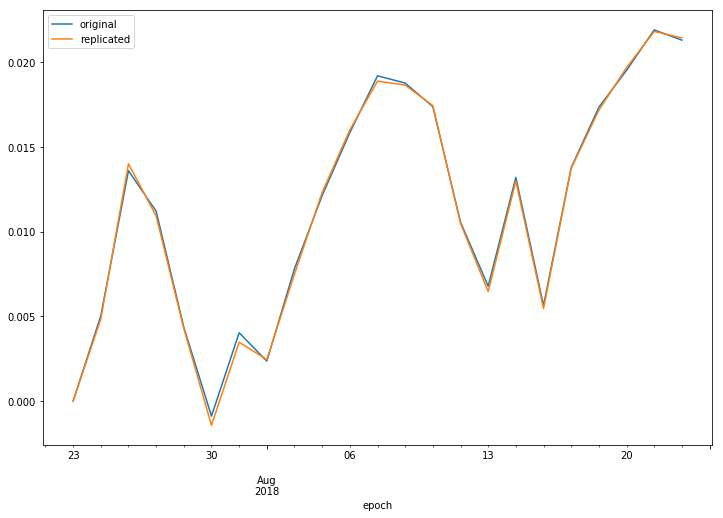

In [11]:
plt.figure(figsize=(12, 8))
performance.plot(figsize=(12, 8))

# What if I have only 10K?

In [12]:
# This is to recalculate the weights at day 1 (instead of using the latest weights that are affected by the price changes)
mktvals = (closes.iloc[0] * constituent.loc['shares'])
weights = mktvals / mktvals.sum()

In [13]:
# Say I have $10K, how many shares would I have bought for each?
cash = 1e+4
new_shares = cash * weights // closes.iloc[0]
positions = pd.DataFrame({
    'shares': new_shares,
    'price': closes.iloc[0],
    'dollar': closes.iloc[0] * new_shares,
}).loc[new_shares > 0]
positions

,dollar,price,shares
AAPL,381.881,190.9403,2
BAC,92.25,30.7500,3
C,69.7702,69.7702,1
CMCSA,34.17,34.1700,1
CSCO,42.06,42.0600,1
F,10.47,10.4700,1
FB,210.91,210.9100,1
GE,38.97,12.9900,3
INTC,51.9938,51.9938,1
JNJ,126.63,126.6300,1


In [14]:
positions.dollar.sum()

2085.6318

In [15]:
new_perf = ((closes - closes.iloc[0]) * new_shares).sum(axis=1) / (closes.iloc[0] * new_shares).sum()

In [16]:
new_result = pd.DataFrame({
    'replicated': new_perf,
    'original': original_perf,
})

In [17]:
new_result

,original,replicated
epoch,,
2018-07-23 00:00:00-04:00,0.000000,0.000000
2018-07-24 00:00:00-04:00,0.005032,0.008330
2018-07-25 00:00:00-04:00,0.013597,0.016651
2018-07-26 00:00:00-04:00,0.011206,-0.003846
2018-07-27 00:00:00-04:00,0.004354,-0.010809
2018-07-30 00:00:00-04:00,-0.000892,-0.013892
2018-07-31 00:00:00-04:00,0.004033,-0.011064
2018-08-01 00:00:00-04:00,0.002355,-0.000900
2018-08-02 00:00:00-04:00,0.007816,0.009131


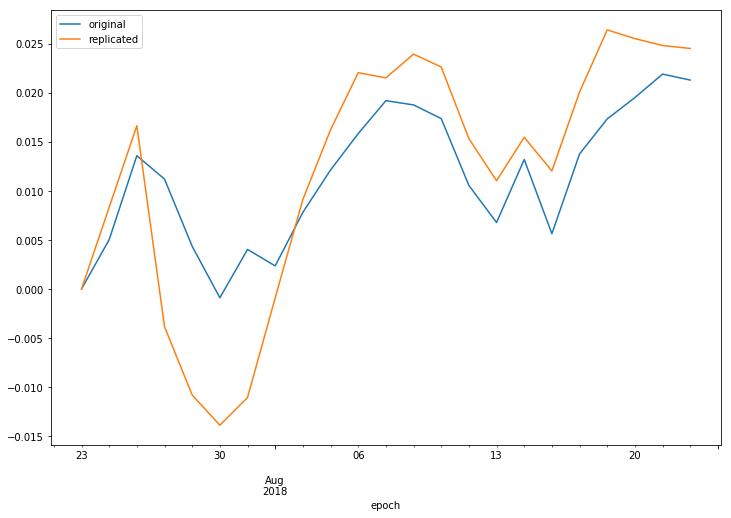

In [18]:
new_result.plot(figsize=(12, 8))